# Model Prediksi Harga Saham PT Indosat Tbk (ISAT.JK)
*Time Series Forecasting* dengan menggunakan SARIMAX

SARIMAX merupakan ekstensi dari model ARIMA (Auto-Regressive Integrated Moving Average).

## 1. Data Preparation

### 1.1. Load the Data, Set Index, and Create Time Series Features from Date

Daily data from 18 September 2018 - 18 September 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import SARIMAX_utils as su
import visualization_utils as vu
import eval_utils as eu
import imp
imp.reload(su)
imp.reload(vu)
imp.reload(eu)

<module 'eval_utils' from '/Users/intanmaharani/Desktop/Semester I August 2022/IF5171 - Pembelajaran Mesin DSAI/TUBES - TIME SERIES FORECASTING/deliverables/eval_utils.py'>

In [3]:
# Load the data
df = pd.read_csv('./datasets/ISAT.JK.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-09-18,2970.0,3000.0,2960.0,2960.0,2565.822021,93600.0
1,2018-09-19,2960.0,3000.0,2960.0,2970.0,2574.490479,62900.0
2,2018-09-20,2970.0,3000.0,2950.0,2980.0,2583.158691,240300.0
3,2018-09-21,2990.0,3000.0,2990.0,3000.0,2600.495361,119100.0
4,2018-09-24,3000.0,3000.0,2980.0,2980.0,2583.158691,82600.0


In [4]:
df2 = df[:]
df2 = df2[['Date', 'Close']]
df2.head()

,Date,Close
0,2018-09-18,2960.0
1,2018-09-19,2970.0
2,2018-09-20,2980.0
3,2018-09-21,3000.0
4,2018-09-24,2980.0


In [5]:
# Convert Date attribute type to pandas to_datetime
df2['Date'] = pd.to_datetime(df2['Date'])

In [6]:
df2.head()

,Date,Close
0,2018-09-18,2960.0
1,2018-09-19,2970.0
2,2018-09-20,2980.0
3,2018-09-21,3000.0
4,2018-09-24,2980.0


In [7]:
# Set Date attribute as index
df2 = df2.set_index('Date')

In [8]:
df2.head()

,Close
Date,
2018-09-18,2960.0
2018-09-19,2970.0
2018-09-20,2980.0
2018-09-21,3000.0
2018-09-24,2980.0


In [9]:
# Check NaN values
df2[df2['Close'].isna()]
df2 = df2[:].dropna()
df2[df2['Close'].isna()]

,Close
Date,


## 2. Exploratory Data Analysis (EDA)
### 2.1. Close Price Plot

In [10]:
def plot_close_by_time (df):
    plt.subplots(figsize=(10, 5))
    plt.plot(df['Close'], label="Close Price")
    plt.grid(True)
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.title('ISAT.JK Close Price Over Time', fontsize=12)
    plt.show()

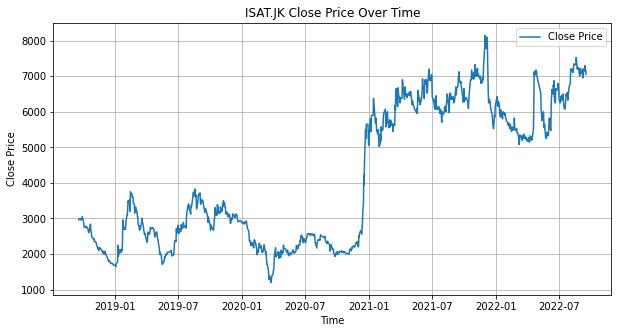

In [11]:
plot_close_by_time(df2)

### 2.2. Understanding the Time Series Data
Dekomposisi time series data menjadi beberapa komponen:
- Trend
- Seasonality
- Random noise

Additive model = Trend + Seasonality + Random Noise

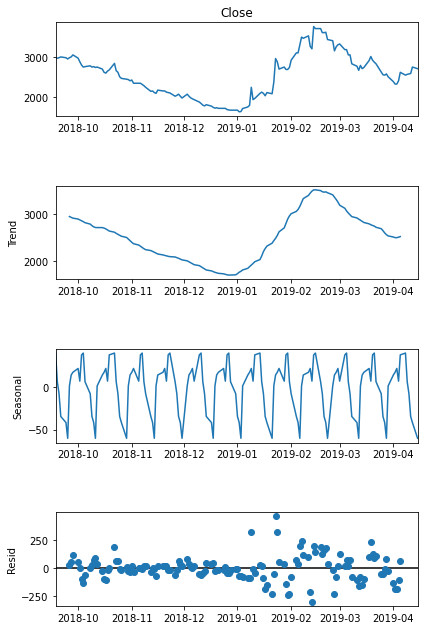

In [18]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(df2['Close'][:150],model='additive',period=12);
fig=seas_d.plot()
fig.set_figheight(10)
plt.show()

The Seasonal plot reveals the existence of seasonal components as it shows waves of ups & downs.

### 2.3. Check the Stationarity of the Data

In [19]:
su.adfuller_test(df2['Close'])

ADF Test Statistic : -0.9805420570793868
p-value : 0.7602948218521037
#Lags Used : 8
Number of Observations Used : 983
Weak evidence against the null hypothesis. Data is NOT stationary.


Based on the ADF Test perfomed above, the data is not stationer. Therefore, differencing needs to be performed to make the data stationer.

### 2.4. Differencing

In [20]:
from statsmodels.tsa.statespace.tools import diff

In [21]:
diffed = diff(df2['Close'],seasonal_periods=20)

In [22]:
# Perform ADF Test Again to Verify Its Stationarity
su.adfuller_test(diffed)

ADF Test Statistic : -11.06582833864988
p-value : 4.68449441949909e-20
#Lags Used : 7
Number of Observations Used : 983
Strong evidence against the null hypothesis (H0). Data is stationary.


<AxesSubplot:xlabel='Date'>

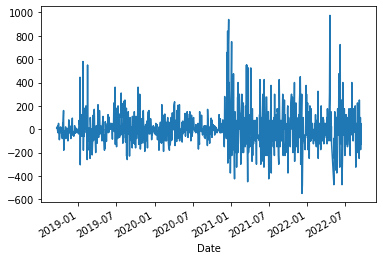

In [23]:
diffed.plot()

## 3. ACF and PACF to determine AR and MA lags
ACF (Autocorrelation) and PACF (Partial Autocorrelation)

p, d, q

- p: AR model lags
- d: differencing
- q: MA lags

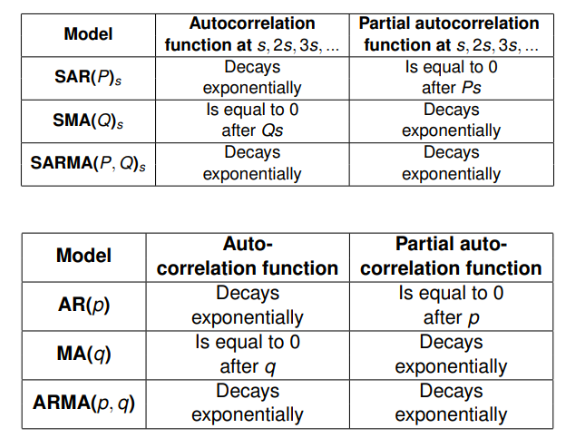

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

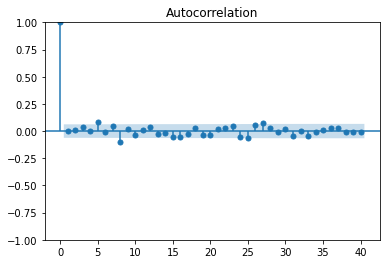

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


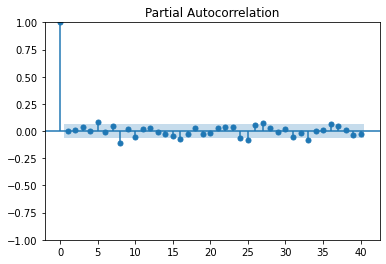

In [25]:
fig = plot_acf(diffed, lags=40) 
plt.show()
fig = plot_pacf(diffed, lags=40)
plt.show()

Parameters:

- d: differencing -> 1

## 4. Modeling using SARIMAX
https://quan-possible.github.io/energy-demand-prediction/daily

In [26]:
import statsmodels.api as sm

### 4.1. Exogenous Variable - December Effect and January Effect

In [27]:
import numpy as np

In [28]:
exog = df2.copy()
# df2.index.month
exog['month'] = df2.index.month
exog['Dec-Jan Effect'] = exog.apply(su.compute_exog_dec_jan_effect, axis = 1)

In [29]:
exog.head()

,Close,month,Dec-Jan Effect
Date,,,
2018-09-18,2960.0,9,0
2018-09-19,2970.0,9,0
2018-09-20,2980.0,9,0
2018-09-21,3000.0,9,0
2018-09-24,2980.0,9,0


### 4.2. Model Estimation
Experiment Strategy: One Factor at a Time

**ACF PLOT**

Used to determine q and Q - Moving Average Order. From the plot below, we will start with q and Q equal to 1.
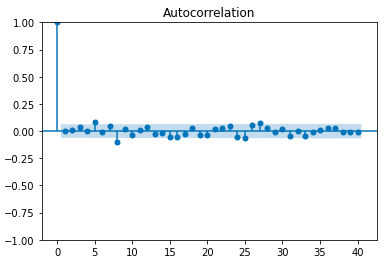

**PACF PLOT**

Used to determine p and P - Autoregressive Order. From the plot below, we will start with p and P equal to 1.
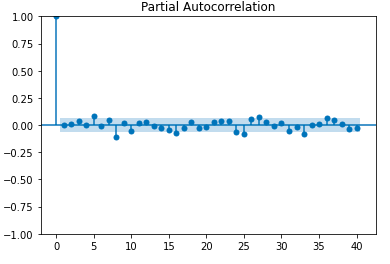

**Differencing was performed once**

The data was stationary after performing 1 differencing. Therefore, values for both d and D are 1.

**s Parameter - Periodicity**

The data was decomposed to trend, seasonal, and residual. From the seasonal plot below, it can be seen that there is a montly repeated cycle. For each month, there are approximately 20 observations (business days), thus, the value of s parameter will be set to 20.
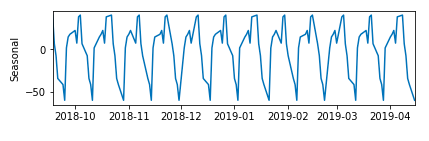

**trend Parameter**

trend controls the deterministic trend polynomial *A(t)*. Value 'c' indicates a constant, 't' indicates a linear trend with time, and 'ct' is both.

In [30]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
X = exog[['Dec-Jan Effect']]
X.index = exog.index
X.head(2)

,Dec-Jan Effect
Date,
2018-09-18,0
2018-09-19,0


In [32]:
y = df2[['Close']]
y.index = df2.index
y.head(2)

,Close
Date,
2018-09-18,2960.0
2018-09-19,2970.0


**Split the data: 80% training and 20% test**

In [33]:
train_size=int(len(df2) * 0.8)
test_size = int(len(df2)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

**Evaluation Helper Function**

In [34]:
# Dictionary to store each experiment's performance
models_performance = {}

In [35]:
from statsmodels.tools.eval_measures import rmse

In [36]:
def get_prediction(model, modelID):
    # Predictions
    pred = model.predict(start = train_size, 
                                  end = (train_size + test_size - 1), 
                                  exog = test_X)

    pred = pd.DataFrame(pred)
    pred.reset_index(drop=True, inplace=True)
    pred.index = test_X.index
    pred['Actual'] = test_y['Close']
    pred.rename(columns={'predicted_mean':'Prediction'}, inplace=True)

    pred['Actual'].plot(figsize=(20,8), legend=True, color='blue')
    pred['Prediction'].plot(legend=True, color='red', figsize=(20,8))
    
    vu.plot_train_test_pred(train_y['Close'], test_y['Close'], pred['Prediction'])
    
    rmse_=rmse(pred['Prediction'], pred['Actual'])
    mape_ = eu.mape(pred['Actual'], pred['Prediction'])
    
    models_performance[modelID] = {'RMSE': rmse_, 'MAPE': mape_}

#### 4.2.1 Define Model #1
SARIMAX (1,1,1) x (1,1,1,20)

In [37]:
model1 = SARIMAX(train_y,exog = train_X, order=(1,1,1),
                 seasonal_order=(1,1,1,20)).fit(maxiter=200)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.39201D+00    |proj g|=  4.88419D-02


 This problem is unconstrained.



At iterate    5    f=  6.37240D+00    |proj g|=  8.21783D-03

At iterate   10    f=  6.36502D+00    |proj g|=  7.01735D-03

At iterate   15    f=  6.26987D+00    |proj g|=  6.93325D-03

At iterate   20    f=  6.26873D+00    |proj g|=  1.72365D-03

At iterate   25    f=  6.26849D+00    |proj g|=  2.75904D-05

At iterate   30    f=  6.26849D+00    |proj g|=  5.78949D-04

At iterate   35    f=  6.26846D+00    |proj g|=  4.30249D-03

At iterate   40    f=  6.26789D+00    |proj g|=  8.08388D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     52      1     0     0   3.372D-05   6.268D+00
  F =   6.26782993398

In [38]:
print(model1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  793
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 20)   Log Likelihood               -4970.389
Date:                            Sun, 16 Oct 2022   AIC                           9952.778
Time:                                    00:58:24   BIC                           9980.672
Sample:                                         0   HQIC                          9963.512
                                            - 793                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Dec-Jan Effect    34.1939     76.930      0.444      0.657    -116.586     184.974
ar.L1             -0.86

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


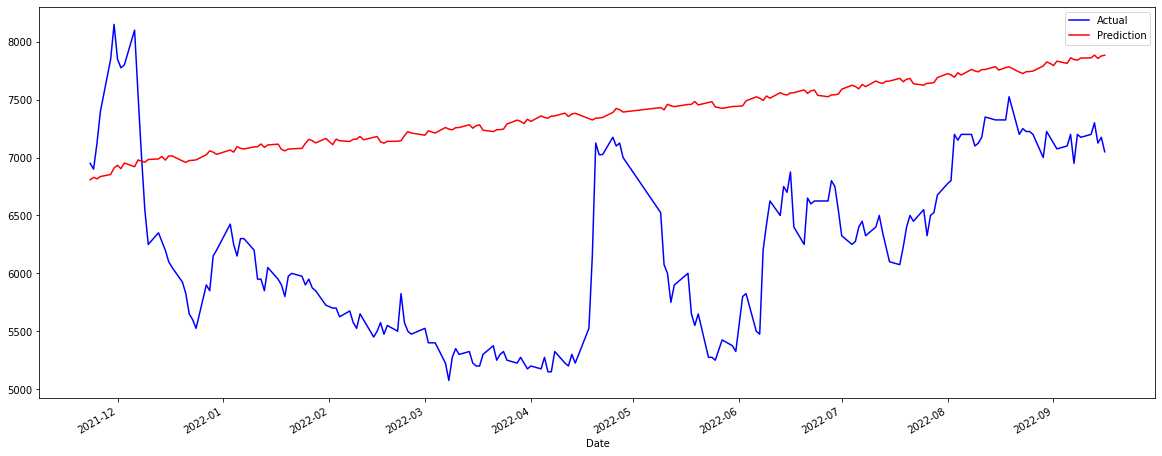

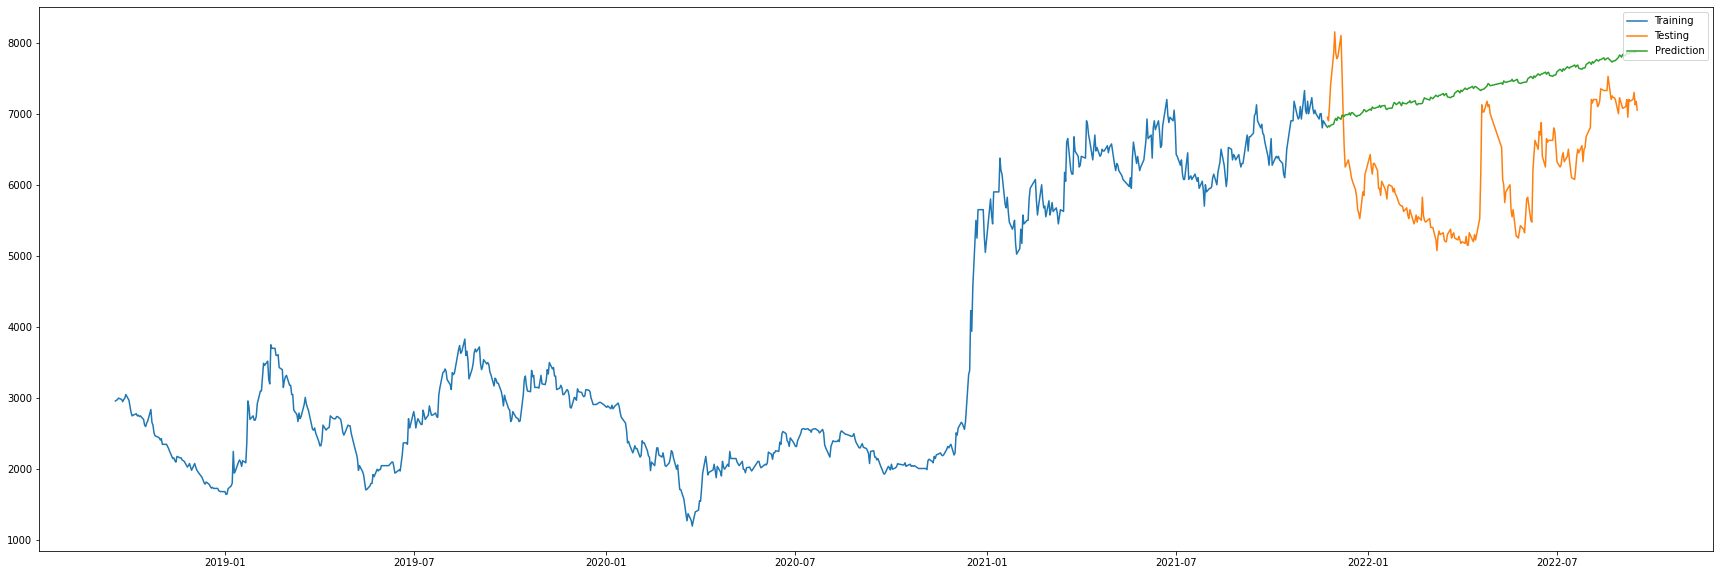

{'RMSE': 1342.9863992685812, 'MAPE': 20.812070101662}


In [39]:
get_prediction(model1, 'MODEL#1')
print(models_performance['MODEL#1'])

#### 4.2.2 Define Model #2
SARIMAX (0,1,1) x (0,1,1,20)

In [40]:
model2 = SARIMAX(train_y,exog = train_X, order=(0,1,1),
                seasonal_order=(0,1,1,20)).fit(maxiter=200)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38096D+00    |proj g|=  2.20026D-02

At iterate    5    f=  6.37234D+00    |proj g|=  2.32053D-03

At iterate   10    f=  6.26961D+00    |proj g|=  9.09789D-04

At iterate   15    f=  6.26960D+00    |proj g|=  1.73609D-03

At iterate   20    f=  6.26904D+00    |proj g|=  1.37862D-02

At iterate   25    f=  6.26883D+00    |proj g|=  6.22427D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   

In [41]:
print(model2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  793
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 20)   Log Likelihood               -4971.179
Date:                            Sun, 16 Oct 2022   AIC                           9950.357
Time:                                    00:59:24   BIC                           9968.953
Sample:                                         0   HQIC                          9957.513
                                            - 793                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Dec-Jan Effect    29.2040     81.196      0.360      0.719    -129.938     188.346
ma.L1             -0.07

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


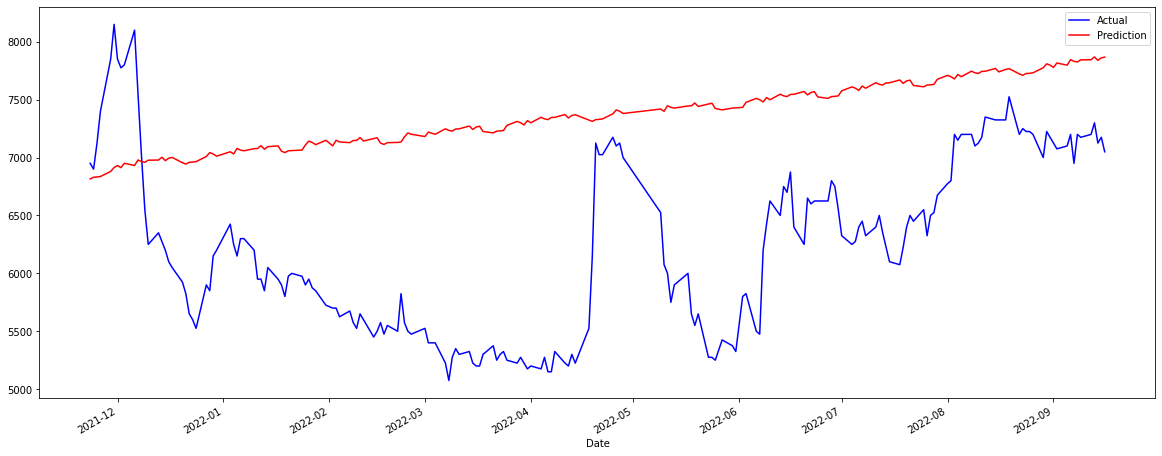

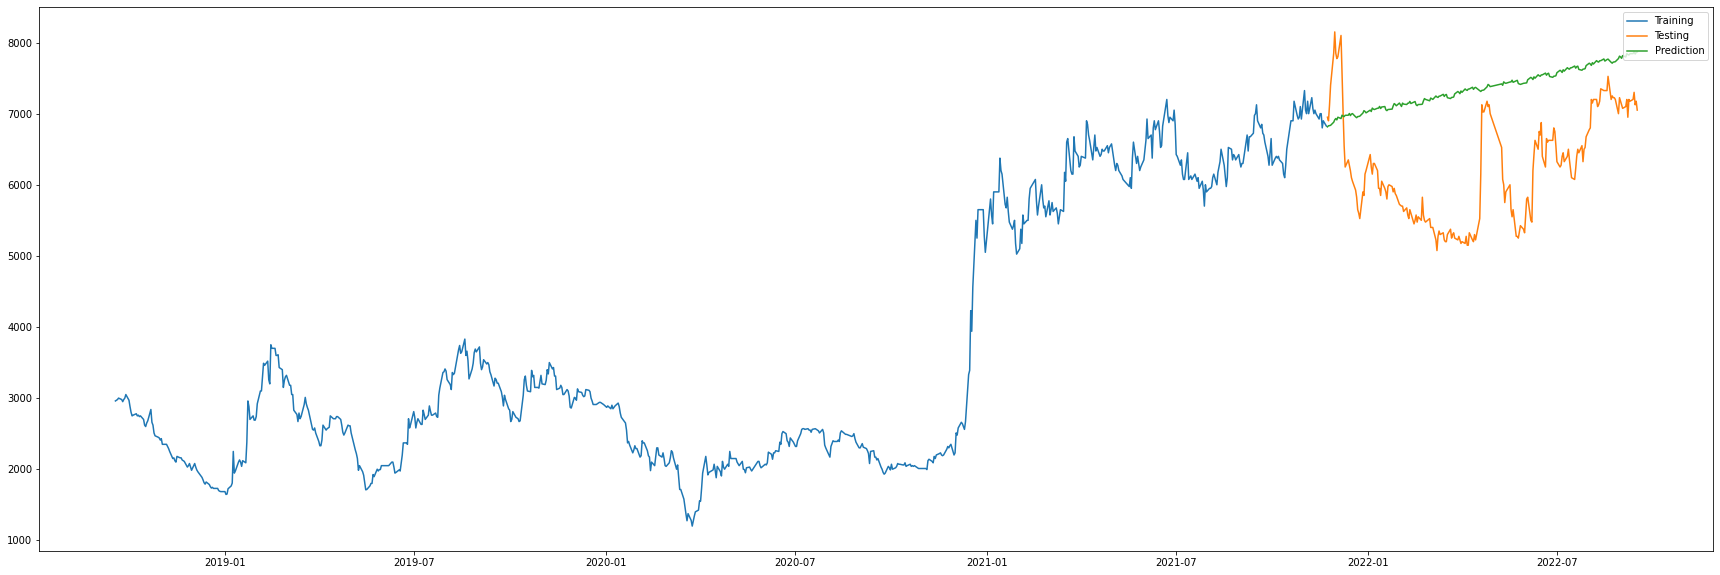

{'RMSE': 1331.350295168797, 'MAPE': 20.602281978831012}


In [42]:
get_prediction(model2, 'MODEL#2')
print(models_performance['MODEL#2'])

#### 4.2.3 Define Model #3
SARIMAX (0,1,0) x (0,1,1,20)

In [43]:
model3 = SARIMAX(train_y,exog = train_X, order=(0,1,0),
                seasonal_order=(0,1,1,20)).fit(maxiter=200)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31835D+00    |proj g|=  3.72882D-02

At iterate    5    f=  6.29608D+00    |proj g|=  1.56988D-03

At iterate   10    f=  6.27197D+00    |proj g|=  4.12456D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   2.753D-06   6.271D+00
  F =   6.2713378680446468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [44]:
print(model3.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  793
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 20)   Log Likelihood               -4973.171
Date:                              Sun, 16 Oct 2022   AIC                           9952.342
Time:                                      01:00:08   BIC                           9966.289
Sample:                                           0   HQIC                          9957.709
                                              - 793                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Dec-Jan Effect    32.5413     82.650      0.394      0.694    -129.450     194.532
ma.S.L2

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


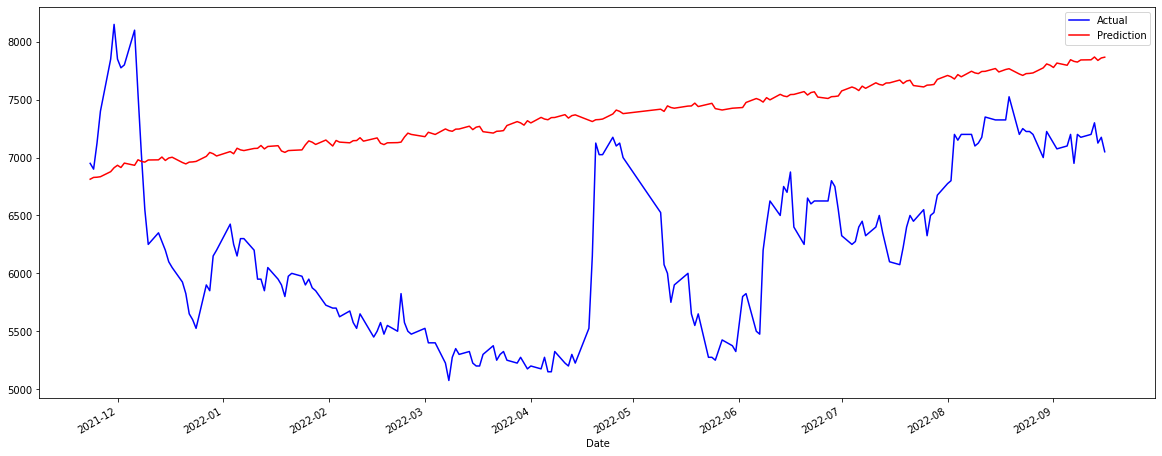

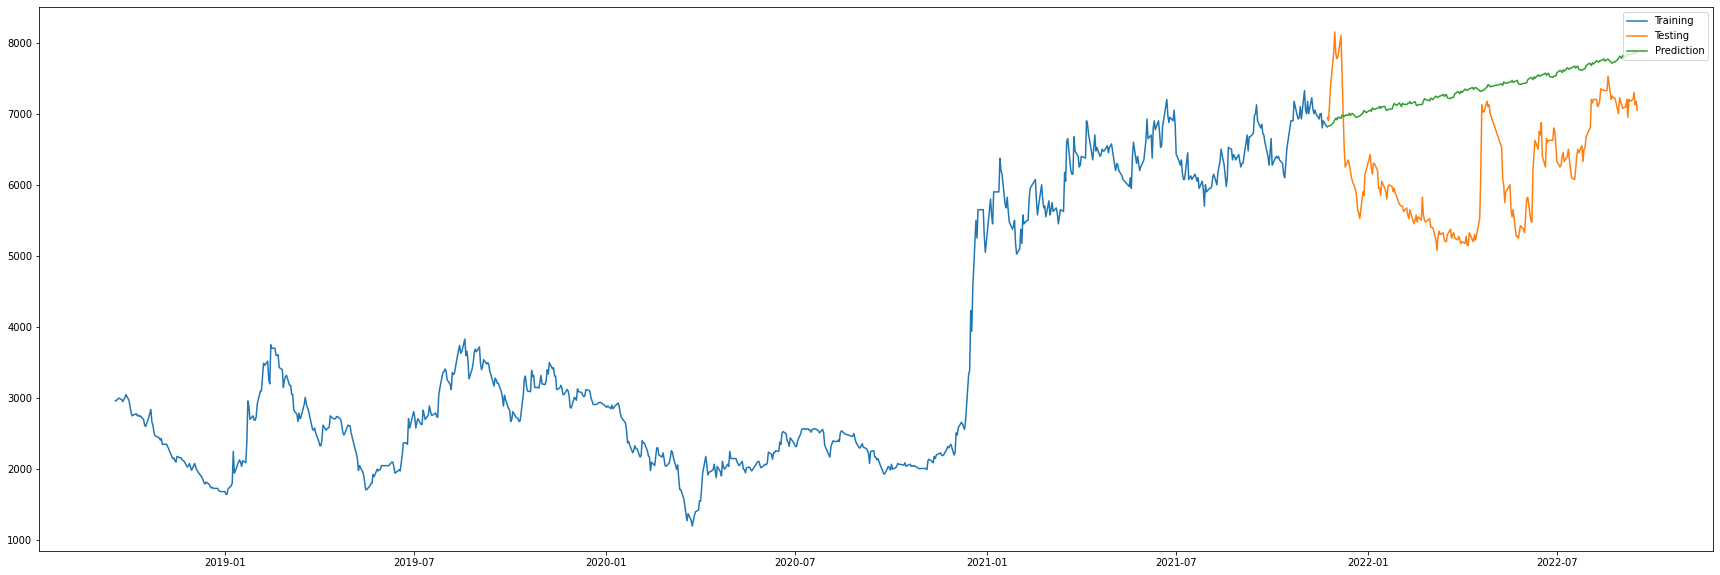

{'RMSE': 1330.789377180857, 'MAPE': 20.594828248392965}


In [45]:
get_prediction(model3, 'MODEL#3')
print(models_performance['MODEL#3'])

#### 4.2.4 Define Model #4
SARIMAX (0,1,0) x (0,1,0,20)

In [46]:
model4 = SARIMAX(train_y,exog = train_X, order=(0,1,0),
                 seasonal_order=(0,1,0,20)).fit(maxiter=300)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34569D+00    |proj g|=  1.65183D-04
  ys=-8.500E+00  -gs= 9.021E-01 BFGS update SKIPPED

At iterate    5    f=  6.59540D+00    |proj g|=  5.79226D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     28      2     1     0   7.142D-06   6.595D+00
  F =   6.5953604296539821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [47]:
print(model4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  793
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 20)   Log Likelihood               -5230.121
Date:                            Sun, 16 Oct 2022   AIC                          10464.242
Time:                                    01:01:04   BIC                          10473.540
Sample:                                         0   HQIC                         10467.819
                                            - 793                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Dec-Jan Effect    95.8333     57.009      1.681      0.093     -15.902     207.569
sigma2          4.481e+

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


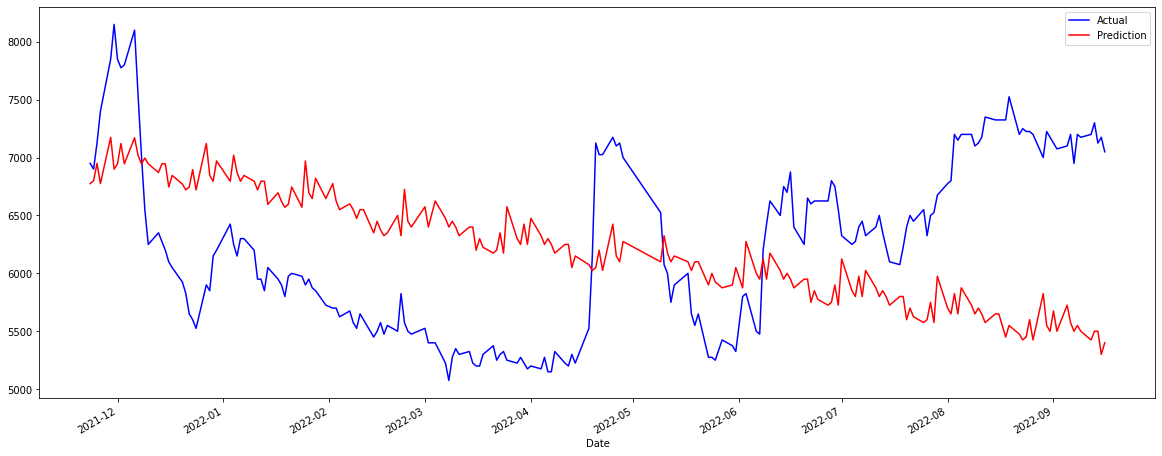

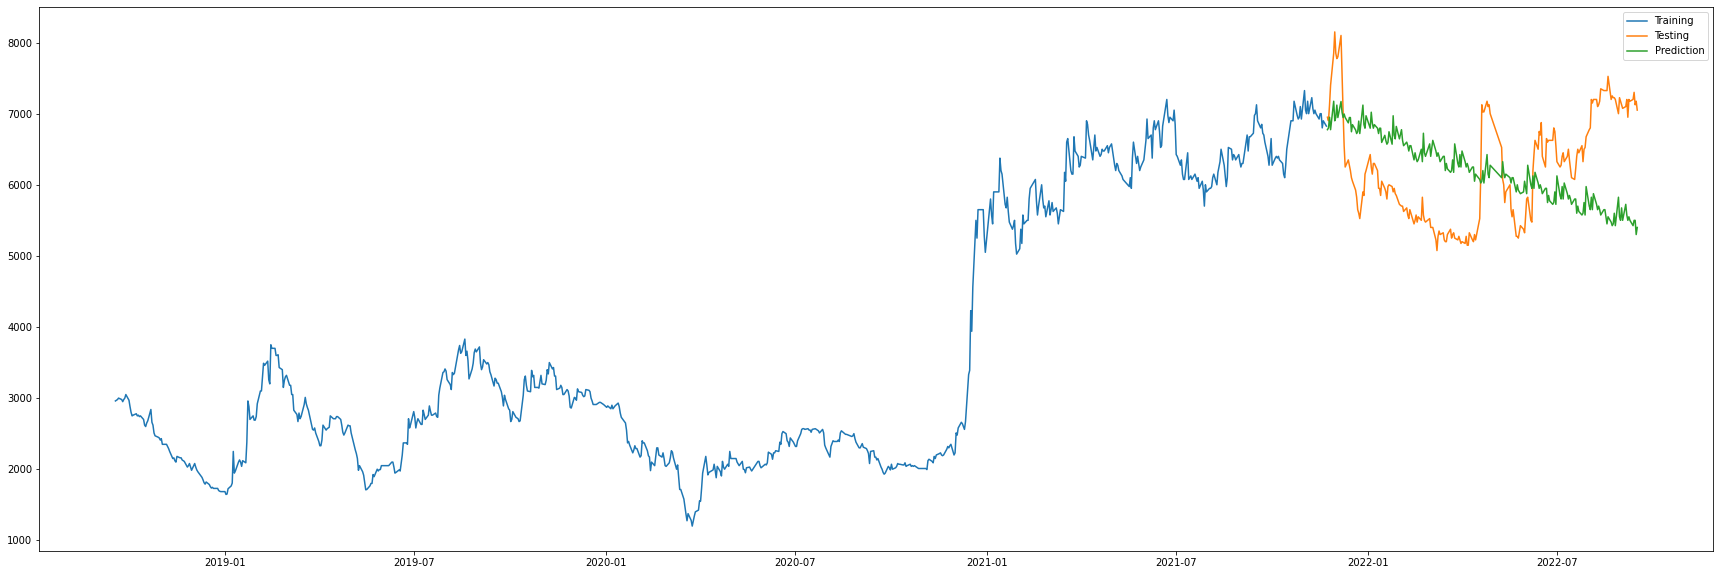

{'RMSE': 993.3460458943459, 'MAPE': 14.459949934349373}


In [48]:
get_prediction(model4, 'MODEL#4')
print(models_performance['MODEL#4'])

#### 4.2.5 Define Model #5
SARIMAX (0,1,0) x (0,1,0,20)

trend = 'c'

In [49]:
model5 = SARIMAX(train_y,exog = train_X, order=(0,1,0),
                 seasonal_order=(0,1,0,20), trend='c').fit(maxiter=300)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59536D+00    |proj g|=  1.77636D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   1.776D-10   6.595D+00
  F =   6.5953591863628116     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [51]:
print(model5.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  793
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 20)   Log Likelihood               -5230.120
Date:                            Sun, 16 Oct 2022   AIC                          10466.240
Time:                                    01:02:13   BIC                          10480.187
Sample:                                         0   HQIC                         10471.606
                                            - 793                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.2461      7.635      0.032      0.974     -14.719      15.211
Dec-Jan Effect    95.83

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


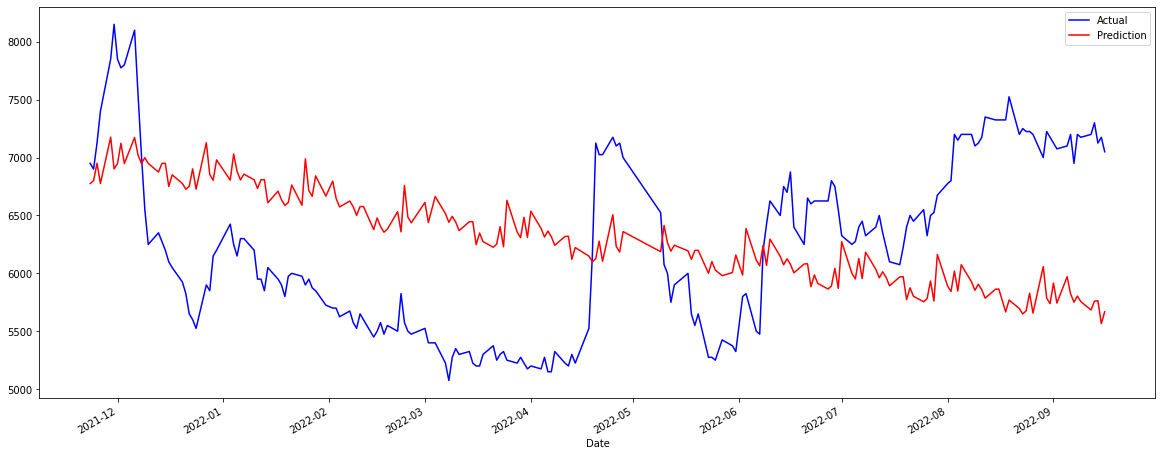

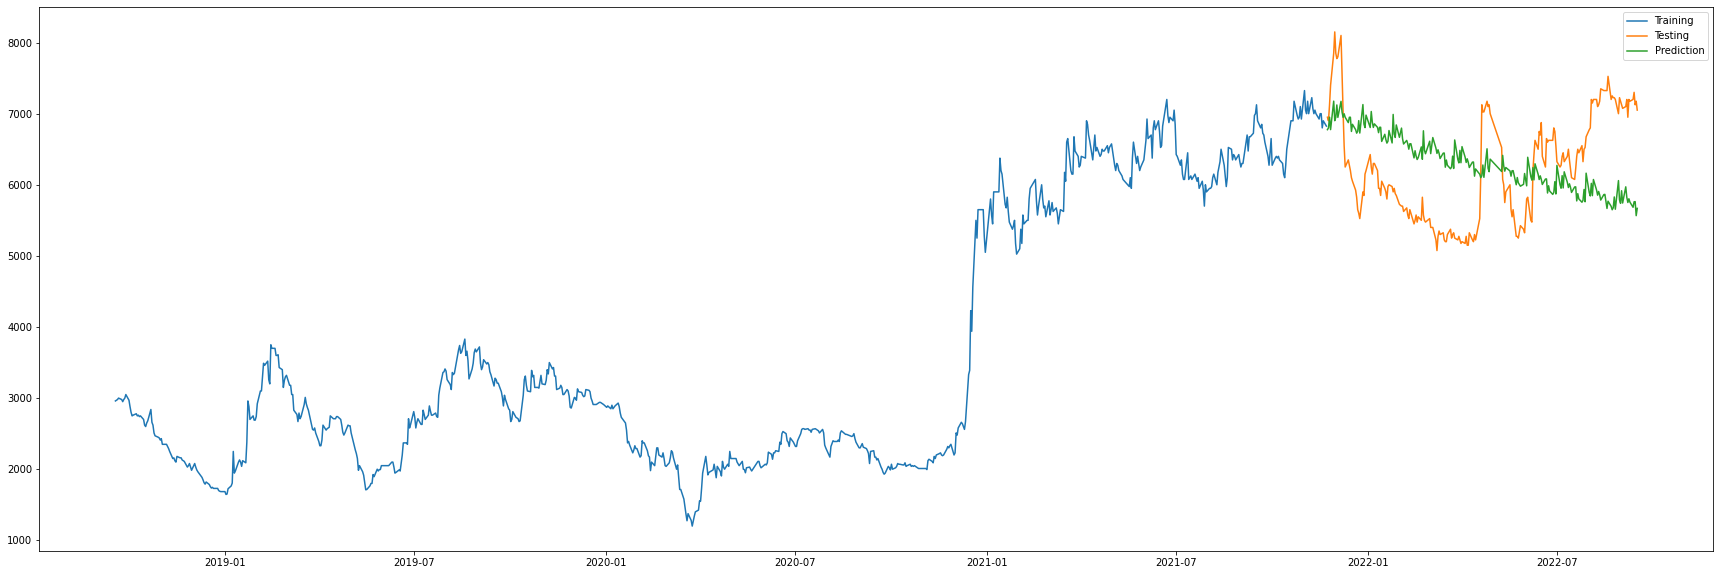

{'RMSE': 932.5760331196329, 'MAPE': 13.837383426077476}


In [50]:
get_prediction(model5, 'MODEL#5')
print(models_performance['MODEL#5'])

## 5. Conclusion

In [52]:
models_performance

{'MODEL#1': {'RMSE': 1342.9863992685812, 'MAPE': 20.812070101662},
 'MODEL#2': {'RMSE': 1331.350295168797, 'MAPE': 20.602281978831012},
 'MODEL#3': {'RMSE': 1330.789377180857, 'MAPE': 20.594828248392965},
 'MODEL#4': {'RMSE': 993.3460458943459, 'MAPE': 14.459949934349373},
 'MODEL#5': {'RMSE': 932.5760331196329, 'MAPE': 13.837383426077476}}

From the performance measures above for each model, it can be seen that **MODEL#5 performed the best with MAPE of 13.84% and RMSE of 932.58**.
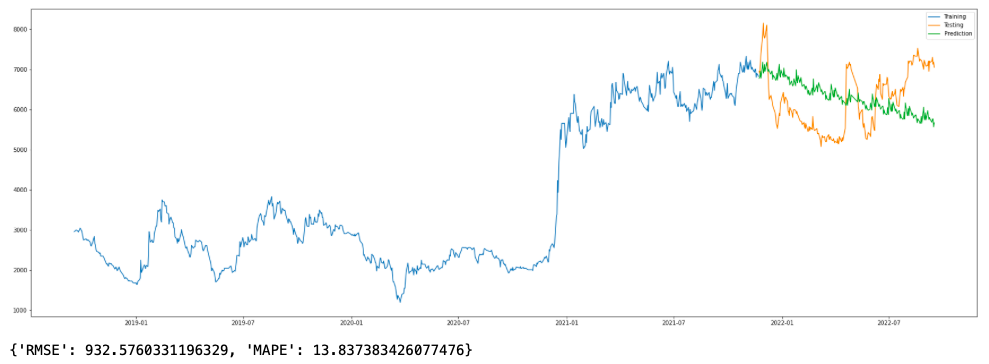

In [53]:
# Save model using joblib (as a file)
from joblib import dump, load
# dump(model5, './models/SARIMAX/ISAT_model5.joblib') 

['./models/SARIMAX/ISAT_model5.joblib']